In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
from emcee import EnsembleSampler
from emcee.moves import DEMove, DESnookerMove
import corner

In [2]:
def train_PCA_GPE(training_data, theta, primary_components = 2): 
    ss = StandardScaler()
    training_data_scaled = ss.fit_transform(training_data)    
    pca = PCA(n_components = primary_components, whiten = True)
    training_data_PCAd = pca.fit_transform(training_data_scaled)
    gpes = []
    
    for z in training_data_PCAd.T[:primary_components]: # optimize hyper parameters for each pc
        kernel = 1 * RBF(length_scale = 1 * np.ones(theta.shape[1]), length_scale_bounds = (1e-10, 1e10)) + 1 * WhiteKernel()
        gpe = GaussianProcessRegressor(kernel = kernel,  n_restarts_optimizer = 5) #, normalize_y = True)
        gpes.append(gpe.fit(theta, z))
    
    return gpes, pca, ss

def invert_cov(cov, var_trans, nsamples, nkp):
    return np.dot(np.array(cov).T, var_trans).reshape(nsamples, nkp, nkp) # A.T * cov * A ?

def return_predictions(emulators, theta, return_std_ = True): # fix for return_std = False
    gpes = emulators[0]
    pca = emulators[1]
    ss = emulators[2]
    nsamples = len(theta)
    npc = len(gpes) # number of principal components
    nkp = np.shape(ss.scale_)[0] # number of kinematical points
                   
    mean_prediction = []
    cov_prediction = []
    
    for gpe in gpes: # predicts per principal component: len(gpes) = npc 
        
        mean, cov = gpe.predict(theta, return_cov = return_std_)
        gp_var2 = cov.diagonal()[:, np.newaxis]
        
        mean_prediction.append(mean)
        cov_prediction.append(gp_var2)

    # inverse transform mean prediction
    pred_r = ss.inverse_transform(pca.inverse_transform(np.array(mean_prediction).T))
    
    # make transformation matrix for error
    trans_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) # transformation matrix
    A = trans_matrix[:npc] 
    var_trans = np.einsum('ki,kj->kij', A, A, optimize = False).reshape(npc, nkp**2)
    
    # inverse transform diagonal covariance matrix
    cov_rpca = invert_cov(cov_prediction, var_trans, nsamples, nkp)
    std_preds = np.sqrt(np.diagonal(cov_rpca, axis1 = 1, axis2 = 2)) # standard devs are just
    err_r = ss.scale_ * std_preds
    
    return pred_r, err_r

# log formulas

# log likelihood
def log_likelihood(theta, emulators, data, data_err): # one set of theta only
    theta_reshaped = theta.reshape(1,-1)
    predict, predict_err = return_predictions(emulators, theta_reshaped, return_std_ = True)    
    err2 = (predict_err**2 + (data_err)**2) 
    ll = np.log(2*np.pi*err2) + ((data - predict)**2) / err2 #np.log is natural log 
    return -.5*np.sum(ll)

# some flat prior that sets the bounds of the parameters
def log_flat_prior(theta, l_bounds, u_bounds):
    
    for i in range(np.size(theta)): # check if each parameter is within bounds
        if theta[i] < l_bounds[i] or theta[i] > u_bounds[i]:
            return -np.inf
       
    return 0

# posterior
def log_posterior(theta, l_bounds, u_bounds, emulators, data, data_err):
    return log_likelihood(theta, emulators, data, data_err) + log_flat_prior(theta, l_bounds, u_bounds)

# emcee sampler function
def emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, data, data_err, moves = None):
    sampler = EnsembleSampler(n_walkers, 
                              n_params, 
                              log_posterior,
                              moves = moves,
                              #moves = [(DEMove(), 0.8), (DESnookerMove(), 0.2)], 
                              args = [l_bounds, u_bounds, emulators, data, data_err], 
                              threads = 4) # default is stretchmove
    return sampler

def return_samples(p0, l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler):
    burn = sampler.run_mcmc(p0, n_burn, progress = True) # initially train until samples converge
    sampler.reset() # remove burn samples
    run = sampler.run_mcmc(burn, n_samples, progress = True)
    return sampler.get_chain(flat = True)

In [160]:
def plot_model_vs_exp(q2s, ss, model_values, exp_df):
    colors  = ['orange', 'purple', 'brown', 'pink', 'maroon', 'olive', 'cyan', 'magenta', 'teal', 'green']
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])
 
        for i in range(len(model_values)):
            model = [ model_values[i,qq2] for qq2 in Q2_indeces]
            if i == 0:
                plt.plot(xb, model, alpha = 0.8, linewidth = 1.0, color = colors[j], label = "$Q^2 = {}$".format((q2)) +  " GeV$^2$")
            else:
                plt.plot(xb, model, alpha = 0.5, linewidth = 0.3, color = colors[j])
                
        if j == 0:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "Data")        
        else:
            plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.')


    plt.xlabel("$x_{bj}$")
    plt.ylabel("$\sigma_r$ (mb)")
    plt.xscale('log') 
    plt.yscale('log')
    plt.legend()
    return plt.show()


In [161]:
def plot_exp_vs_map_vs_median(q2s, ss, map_values, exp_df, median_values):
    
    colors  = ['orange', 'purple', 'brown', 'pink', 'maroon', 'olive', 'cyan', 'magenta', 'teal', 'green']
    for j in range(len(q2s)):
        q2 = q2s[j]
        Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
        Q2_indeces = exp_df.index[Q2_region].tolist()
        exp_df_region = exp_df[Q2_region]
        dat = np.array(exp_df_region['sigma_r'])
        dat_err = np.array(exp_df_region['error'])
        xb = np.array(exp_df_region['xbj'])

        for i in range(len(map_values)):
            model = [map_values[i,qq2] for qq2 in Q2_indeces]
            plt.plot(xb, model, '--', alpha = 0.9, color = colors[j], label = "MAP estimates")

        for i in range(len(median_values)):
            model = [median_values[i,qq2] for qq2 in Q2_indeces]
            plt.plot(xb, model, alpha = 0.5, color = colors[j], label = " Posterior median")

    # for i in range(len(median_values_low)):
    #     modellow = [median_values_low[i,qq2] for qq2 in Q2_indeces]
    #     modelhigh = [median_values_high[i,qq2] for qq2 in Q2_indeces]
    #     plt.fill_between(xb, modellow, modelhigh, alpha = 0.4, label = "{} credible region".format(confidence))
    
        plt.errorbar(xb, dat, yerr = dat_err, color = 'black', fmt = '.', label = "HERA Data")
    
    #plt.title(r"$Q^2 = {} $".format((q2)) + r" GeV$^2$; $\sqrt{s}$" + " = {} GeV".format(ss))   
    plt.xlabel("$x_{bj}$")
    plt.ylabel("$\sigma_r$ (mb)")
    plt.xscale('log') 
    #plt.legend()
    return plt.show()


In [162]:
def plot_model_vs_exp_wtrain(q2, ss, model_values, exp_df):
    splots = 2
    fig, ax = plt.subplots(1,splots, figsize = (16, 6))

    Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
    Q2_indeces = exp_df.index[Q2_region].tolist()
    exp_df_region = exp_df[Q2_region]
    dat = np.array(exp_df_region['sigma_r'])
    dat_err = np.array(exp_df_region['error'])
    xb = np.array(exp_df_region['xbj'])
    

    for i in range(len(model_values)):
        model = [model_values[i,qq2] for qq2 in Q2_indeces]
        ax[0].plot(xb, model, alpha = 0.3, color = 'orange',linewidth = 0.5)
        if i == len(model_values)-1:
            ax[0].plot(xb, model, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Emulator (Posterior Samples)") 
    
    ax[0].plot(np.average(model))
        
    for i in range(len(training_set_all)):
        train = [training_set_all[i,qq2] for qq2 in Q2_indeces]
        ax[1].plot(xb, train, alpha = 0.3, color = 'orange', linewidth = 0.5)
        if i == len(pred_r)-1:
            ax[1].plot(xb, train, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Training Data")

    for i in range(splots):
        ax[i].errorbar(xb, dat, yerr = dat_err, color = '#0343DF',  fmt = '.', alpha = 0.7, label = "HERA Data")
        ax[i].set_title("$Q^2$ = {} GeV$^{}$; ".format(q2, 2) + "$\sqrt{s}$ = " + str(ss) + " GeV")
        ax[i].set_xlabel("$x_{bj}$")
        ax[i].set_ylabel("$\sigma_r$ (mb)")
        #ax[0].set_ylim(0.5, 2.0)
        ax[i].set_xscale('log') 
        #ax[i].set_yscale('log')
        ax[i].legend()
        
    return plt.show()
 # make cuts
 # check chi2

In [3]:
#fig_label = "4p100d232k"

#folder = "mv5/orthLHS/121d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
folder = "mv5/plainLHS/500d"
train_file, theta_file = [folder + "/train.dat", folder + "/theta.dat"]
exp_file = "exp_all.dat"
param_names = ["$Q_{s0}^{2}$ (GeV²)",
               "$\gamma$",
               "$e_c$",
               "$C^{2}$",
               "$\sigma_0/2$ (mb)"] # ordered
n_params = len(param_names)

# cut training data ()
exp_df = pd.DataFrame(np.loadtxt(exp_file), columns = ['xbj', 'Qs2', 'sqrt(s)', 'sigma_r', 'error'])
a, b = 2.0, 50.0 
# Q2_region = exp_df['Qs2'] < 10.0 # boolean
Q2_region = (exp_df['Qs2'] >= a) & (exp_df['Qs2'] <= b)
Q2_index = exp_df.index[Q2_region].tolist()
exp_df = exp_df[Q2_region]
xbj = np.array(exp_df['xbj'])
exp = np.array(exp_df['sigma_r'])
exp_err = np.array(exp_df['error'])

In [4]:
train_dataset = pd.DataFrame(np.loadtxt(train_file))
train_dataset = train_dataset.iloc[:, Q2_index].T.reset_index(drop=True).T
params_all = np.vstack(np.loadtxt(theta_file, unpack = True)).T
training_set_all = train_dataset.iloc[:,np.array(train_dataset.columns)].values
myparams, myparams_test, training_set, training_set_test = train_test_split(params_all, 
                                                                            training_set_all, 
                                                                            test_size = 0.05, 
                                                                            random_state = 10)

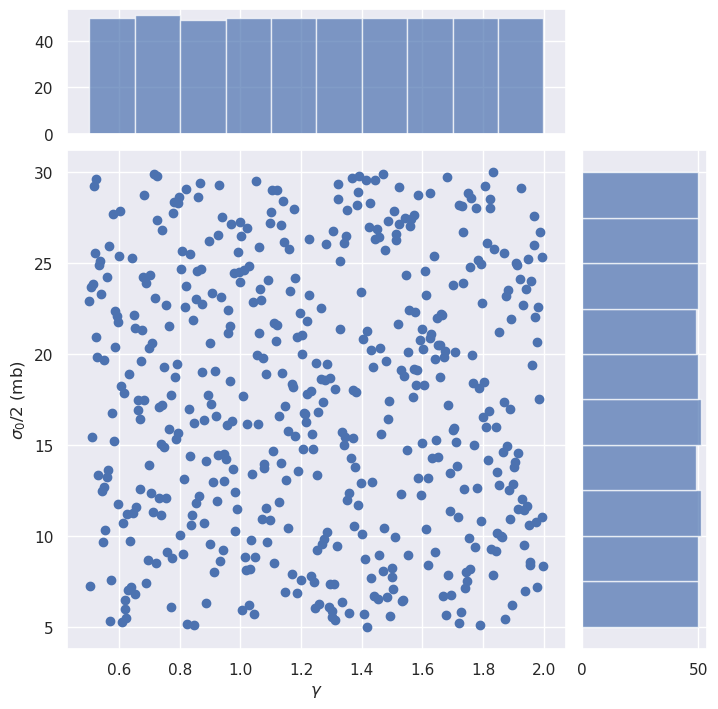

In [38]:
def scatter_hist(a, b, ax, ax_histx, ax_histy):
    # no labels
    x = params_all[:,a]
    y = params_all[:,b]
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax.set_xlabel(param_names[a])
    ax.set_ylabel(param_names[b])
    ax_histx.hist(x, bins=10, alpha=0.7)
    ax_histy.hist(y, bins=10, orientation='horizontal', alpha=0.7)

# Start with a square Figure.
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(1, 4, ax, ax_histx, ax_histy)
#plt.ylabel(r"$\gamma$")

In [409]:
# space for validating() the gpe emulator
# z = np.zeros(20)
# ems = []
# prims = []
# for i in range(20):
#     prim = i + 2
#     prims.append(prim)
#     emulators0 = train_PCA_GPE(training_set, myparams, primary_components = prim)
#     ems.append(emulators0)
#     pred_rs, err_rs = return_predictions(ems[i], myparams_test, return_std_ = True)
#     z_mean = []
#     for f in range(np.shape(pred_rs)[1]):
#         zs = np.mean(np.abs(pred_rs[:,f] - training_set_test[:,f]) / err_rs[:,f])
#         z_mean.append(zs)
#     z[i] = np.mean(z_mean)
#     #z[i] = emulators0[3]
#         #z[i] = np.mean(np.abs(err_rs))

# npc = np.where( z == np.amin(z, axis = 0))[0][0] + 2
# fig = plt.plot(prims, z, '.')
# plt.xlabel("Number of Principal Components")
# plt.ylabel("Mean Relative Difference")

In [6]:
# train pca, scaler, and gpe
npc = 5
emulators = train_PCA_GPE(training_set, myparams, primary_components = npc)
# return predictions of fits
pred_r, err_r = return_predictions(emulators, myparams_test, return_std_ = True)
#pred_r_train, err_r_train = return_predictions(emulators, myparams, return_std_ = True)

1.207 0.013337213460839561
0.0005
[0.05032074 0.04182951 0.05778019 0.17162653 0.11461798 0.05233169
 0.17815127 0.0737592  0.1556567  0.144552   0.14672751 0.03570476
 0.12360441 0.16045723 0.18613667 0.01275892 0.16954589 0.07805395
 0.15044111 0.19771568 0.14099662 0.13092034 0.16408512 0.11511709
 0.15412439]


Text(0, 0.5, '$\\sigma_r$')

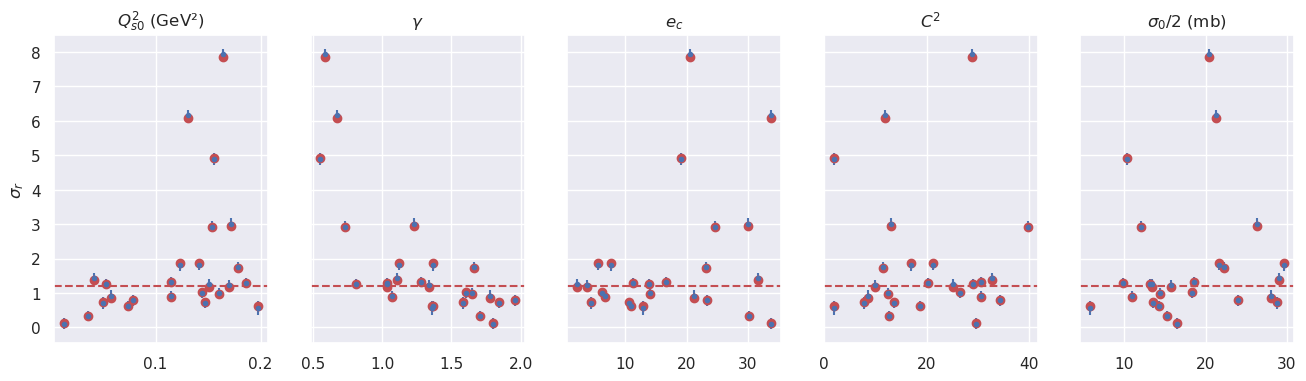

In [7]:
# plot for first kinematical point, comparing training da$Q_{s0}^{2}$ (GeV²)= 0.166
kp = 100
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_test[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Test")
    #ax[i].errorbar(myparams[:,i], pred_r_train[:,kp], fmt = '.', yerr = err_r_train[:,kp], label = "GPE Prediction on Train")
    ax[i].plot(myparams_test[:,i], training_set_test[:,kp], 'ro', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    #ax[i].legend()
    #ax[i].set_ylim(-2, 8)

# ax[1].set_xscale("log")    
print(exp[kp], exp_err[kp])
print(xbj[kp])
print(myparams_test[:,0])
ax[0].set_ylabel(r"$\sigma_r$")

Text(0.5, 0, 'Training Data $\\sigma_r$')

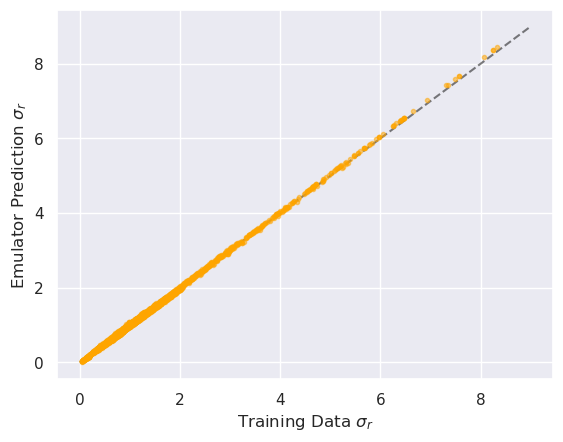

In [166]:
diag = np.linspace(0,9)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(100):
    plt.plot(training_set_test[:,i], pred_r[:,i], '.', color = "orange", alpha = 0.5)

plt.ylabel("Emulator Prediction $\sigma_r$")
plt.xlabel("Training Data $\sigma_r$")
#plt.ylim(0.0, 1.0)
#plt.xlim(0.0, 1.0)

Text(0, 0.5, 'z score')

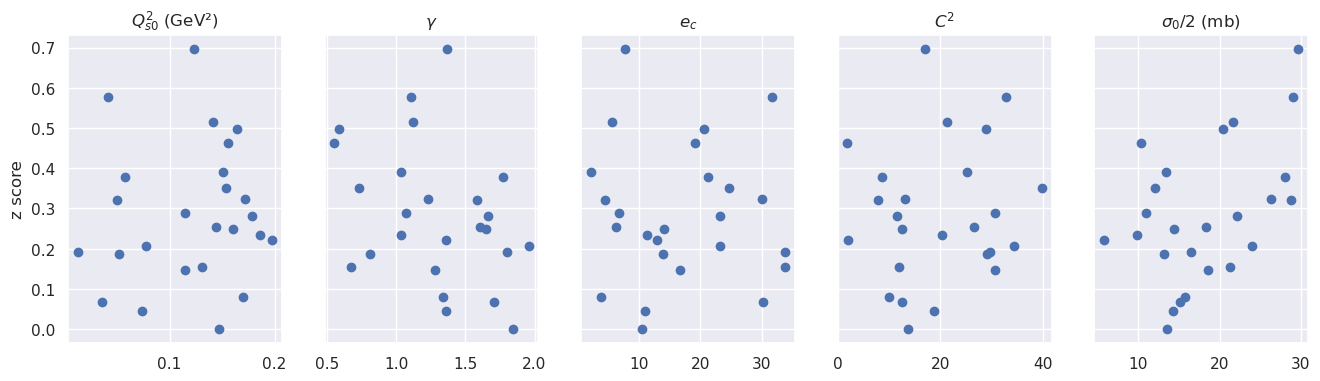

In [12]:
# plot for first kinematical point, comparing training data value and gpe prediction
kp = 50
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].plot(myparams_test[:,i], np.abs(pred_r[:,kp] - training_set_test[:,kp]) / err_r[:,kp], 'o')
    ax[i].set_title(param_names[i])

ax[0].set_ylabel("z score")


(-2.5, 2.5)

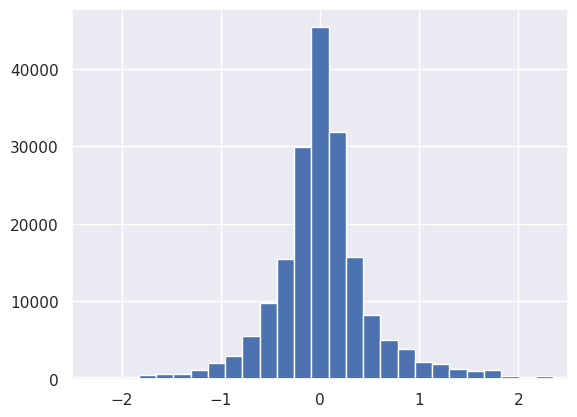

In [22]:
z = np.array([(pred_r_train[:,kp] - training_set[:,kp]) / err_r_train[:,kp] for kp in range(403)])
#z = np.array([(pred_r[:,kp] - training_set_test[:,kp]) / err_r[:,kp] for kp in range(403)])
plt.hist(z.flatten(), bins = 100);
plt.xlim(-2.5,2.5)


In [14]:
# are there still negative values in the err_r
for i in range(len(exp)):
    for num in err_r[:,i]:
        if num < 0:
            print(num, end=" ")

In [16]:
# getting MAP values

from scipy.optimize import minimize, basinhopping
#posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run 
l_bounds = [0.001, 0.5, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 2.0, 40.0, 40.0, 30.0] 
initial_guess = np.array([0.06, 1.0, 18.9, 7.2, 16.36]) # mve from paper

#MAP1 = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess)
MAP1 = minimize(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("Initial Guess for minimize: ", initial_guess)
#print("log likelihood at initial guess:", -log_likelihood(initial_guess, emulators, exp, exp_err))
print("minimize estimates: ", MAP1.x)
print("log likelihod at minimize", MAP1.fun)

map2_kwargs = {"method": "BFGS"}
#MAP2 = basinhopping(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), initial_guess, niter = 200, minimizer_kwargs = map2_kwargs)
MAP2 = basinhopping(lambda theta: -log_likelihood(theta, emulators, exp, exp_err), initial_guess)
print("basinhopping estimates: ", MAP2.x)
print("log likelihood at basinhopping", MAP2.fun)


Initial Guess for minimize:  [ 0.06  1.   18.9   7.2  16.36]
minimize estimates:  [ 0.07434282  1.17502624 15.93596755 10.74950213 17.42731181]
log likelihod at minimize -440.9251820752145
basinhopping estimates:  [ 0.07480615  1.17419272 16.4560255  10.60441225 17.26560648]
log likelihood at basinhopping -440.9307657016201


In [201]:
print("log likelihood at initial guess:", -log_likelihood(initial_guess, emulators, exp, exp_err))

log likelihood at initial guess: 5.300278178216368


In [200]:
# initializes the walkers in either a small space around the initial guess
# or in a larger space. Well we'll see how it goes
# initialize
l_bounds = [0.001, 0.90, 0.5, 0.1, 5.0] # Qs0² , gamma, ec , C², sigma0/2
u_bounds = [0.2, 1.1, 40.0, 40.0, 30.0]

# [ 0.16487977  1.17362474 31.9729632   0.10056809  7.8739019 ]
# [ 0.16429921  1.17286339 32.91302409  0.63792114  7.90410021]
# initialized at final MAP
#l_bounds_in = [0.15, 1.1, 30.0, 0.5, 6.0]
#u_bounds_in = [0.17, 1.2, 34.0, 0.8, 9.0]

mylimits = np.array([l_bounds, u_bounds])
n_walkers = 50
n_burn = 500 # 2000
n_samples = 500

p0 = np.random.uniform(l_bounds, u_bounds, size = (n_walkers,n_params))
sampler1 = emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, exp, exp_err)
paramsamples = return_samples(p0,l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler1)

for i in range(n_params): # print means
    print(param_names[i] + "= {0:.3f}".format(np.mean(paramsamples[:,i])))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler1.acceptance_fraction)))

100%|██████████| 500/500 [02:48<00:00,  2.96it/s]

$Q_{s0}^{2}$ (GeV²)= 0.059
$\gamma$= 1.038
$e_c$= 15.842
$C^{2}$= 16.618
$\sigma_0/2$ (mb)= 18.844
Mean acceptance fraction: 0.212


In [165]:
# here we find the map values after the sampling with the median values as initial guess
posterior_median = np.median(paramsamples, axis = 0) # median values of the posterior as initial guess; code still works for other guesses, it just takes longer to run
MAP = minimize(lambda theta: -log_posterior(theta, l_bounds, u_bounds, emulators, exp, exp_err), posterior_median)
percentile_16 = np.percentile(paramsamples, 16, axis = 0)
percentile_84 = np.percentile(paramsamples, 84, axis = 0)
percentile_5 = np.percentile(paramsamples, 5, axis = 0)
percentile_95 = np.percentile(paramsamples, 95, axis = 0)

print("MAP estimates: ", MAP.x)
print("log posterior at MAP: ", MAP.fun)
print("Median Values: ", posterior_median)
print("log posterior at Median: ", -log_posterior(posterior_median, l_bounds, u_bounds, emulators, exp, exp_err))
print("16th percentile: ", percentile_16)
print("84th percentile: ", percentile_84)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


MAP estimates:  [ 0.07480438  1.17398915 16.21013843 10.70719837 17.31234445]
log posterior at MAP:  -440.92945154847496
Median Values:  [ 0.07196587  1.15987425 16.09102008 10.61822588 17.32809346]
log posterior at Median:  -440.7399017230984
16th percentile:  [ 0.06014059  1.11017707 11.70506078  8.7225691  16.09936817]
84th percentile:  [ 0.08464437  1.200933   21.99990552 12.8544539  18.98131799]
5th percentile:  [ 0.05283204  1.06050005  9.6701435   7.63193461 15.37843949]
95th percentile:  [ 0.09398835  1.23175869 26.93102367 16.86557502 20.24778124]


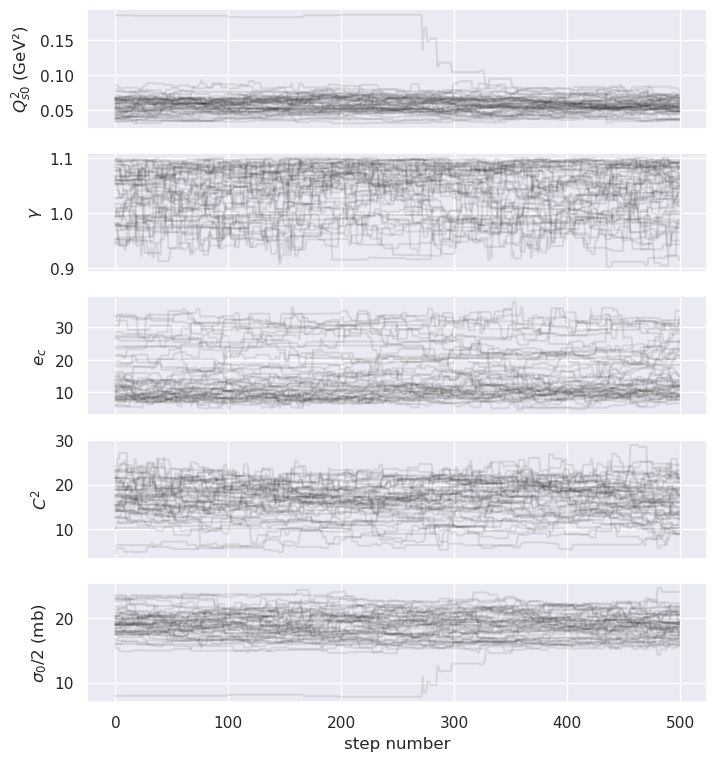

In [202]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.chain[:,:,i].T, color = 'k', alpha = 0.1)
    axes[i].set_ylabel(param_names[i])
    axes[-1].set_xlabel('step number')

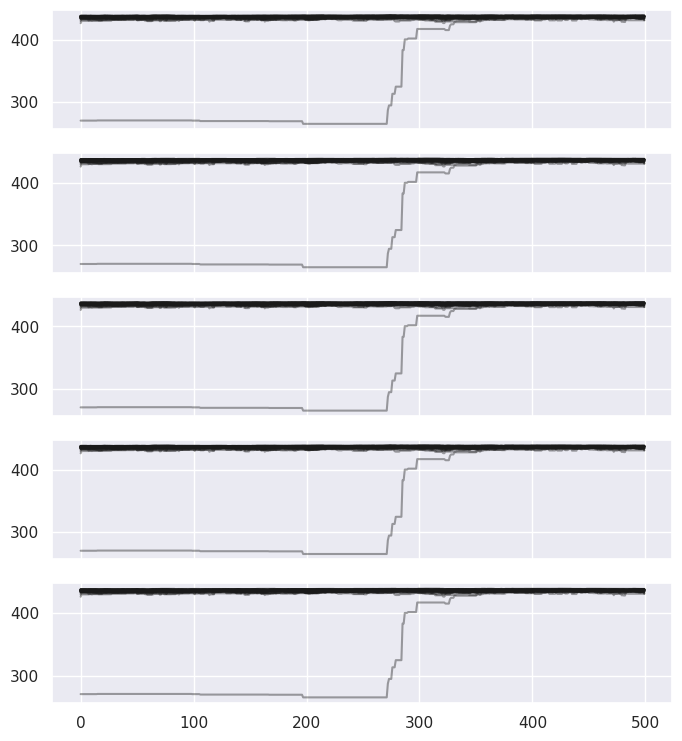

In [203]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.get_log_prob(), color = 'k', alpha = 0.4)
    #axes[i].set_ylim(440, 460)
    #axes[-1].set_xlabel('step number')

In [455]:
# unpack all samples that are saved in txt file
# paramsamples = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_allsamples.txt", unpack = True)).T

Quantiles:
[(0.05, 0.03773396026350113), (0.5, 0.057336624764913864), (0.95, 0.07795740378826345)]
Quantiles:
[(0.05, 0.9531709013336631), (0.5, 1.0498357596805432), (0.95, 1.0951123849831126)]
Quantiles:
[(0.05, 7.208683856345841), (0.5, 12.514272554142698), (0.95, 31.803703110476434)]
Quantiles:
[(0.05, 9.06044259153543), (0.5, 17.12362911285149), (0.95, 22.516720998194085)]
Quantiles:
[(0.05, 15.656078510679741), (0.5, 18.969312083241853), (0.95, 22.340057860210166)]


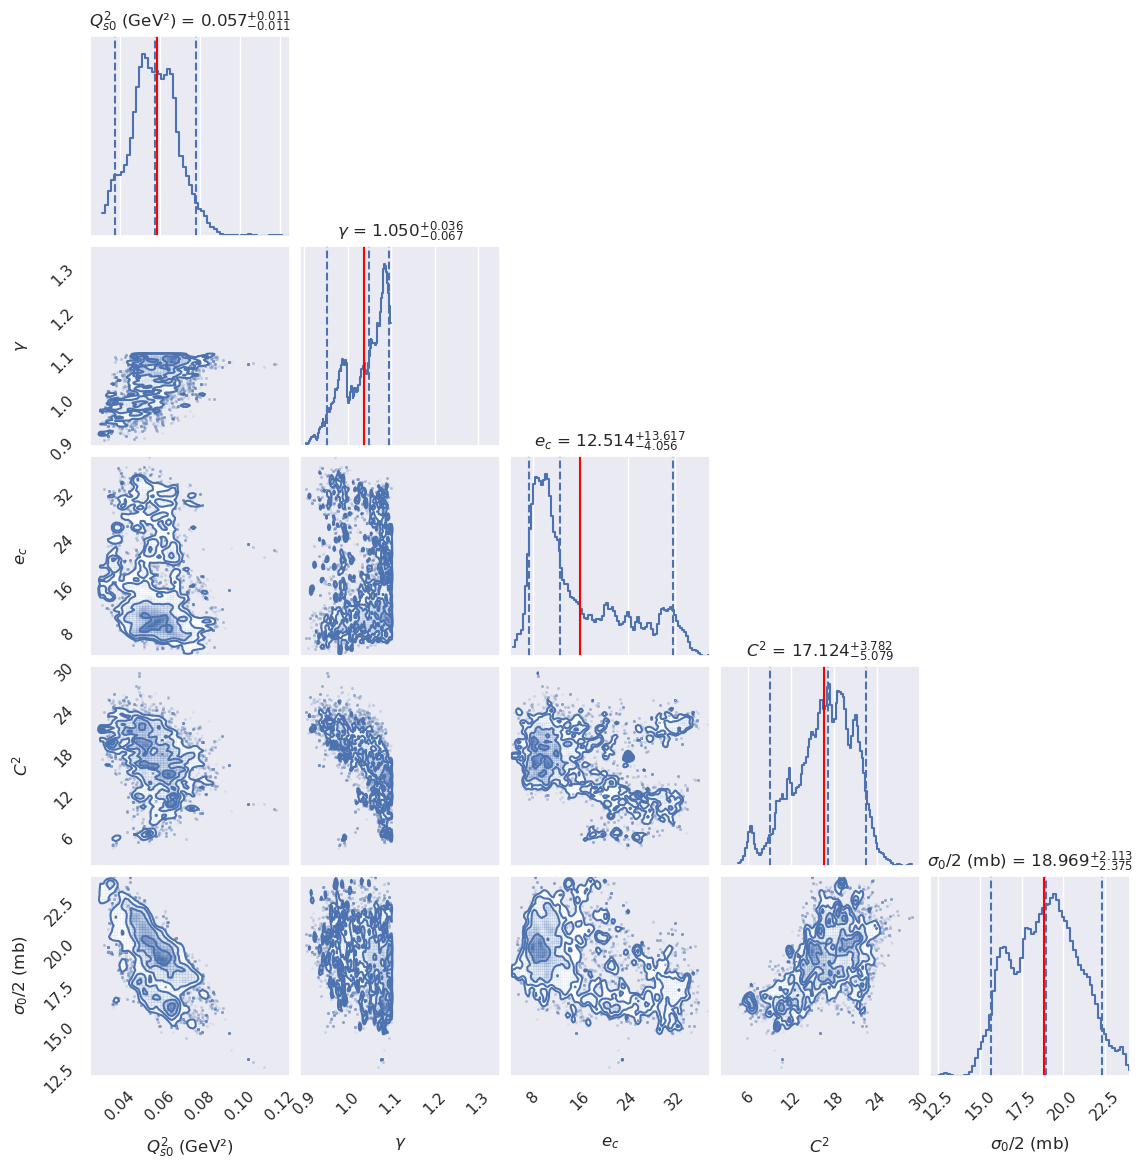

In [204]:
figure = corner.corner(
    paramsamples,
    labels = param_names,
    #plot_contours = True,
    quantiles=[0.05, 0.5, 0.95],
    show_titles = True, # 
    title_fmt = '.3f',
    title_kwargs={"fontsize": 12}, 
    color = 'b',
    bins = 100,
    smooth1d = True,
    smooth = True,
    verbose = True,
    plot_density = True,
    #plot_datapoints = False,
    fillcontours = False, # 
    hist2d_kwargs = {"plot_density": True} # conto
)

ndim = n_params
axes = np.array(figure.axes).reshape((ndim, ndim))
range0 = [0.025, 0.125]
range1 = [0.89,1.35]
range2 = [4.0, 38.0]
range3 = [2.0, 30.0]
range4 = [12.0, 24.0]
ranges = np.array([range0, range1, range2, range3, range4])


import math
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.mean(paramsamples[:,i]), color="red")
    ax.set_xlim(ranges[i])

for yi in range(5):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.set_xlim(ranges[xi])
        ax.set_ylim(ranges[yi])


In [66]:
# # run once
#inds = np.random.randint(len(paramsamples), size=100)
#post_samples = np.array([paramsamples[i] for i in inds])
#np.savetxt("mv5/plainLHS/mv5_500d_100w_sampled_from_posterior_100.txt", np.array(post_samples), delimiter = " ", newline = "\n")
#np.savetxt("mv5/plainLHS/mv5_500d_100w_allsamples.txt", np.array(paramsamples), delimiter = " ", newline = "\n")

In [71]:
post_samples = np.vstack(np.loadtxt("mv5/plainLHS/mv5_500d_100w_sampled_from_posterior_100.txt", unpack = True)).T
model_values, model_values_err = return_predictions(emulators, post_samples, return_std_ = True)

In [133]:
MAPx = MAP.x
MAPT = MAPx.reshape(1,-1)
MAPT_values, MAPT_values_err = return_predictions(emulators, MAPT, return_std_ = True)
median_values, median_values_err = return_predictions(emulators, np.array(posterior_median).reshape(1,-1), return_std_ = True)

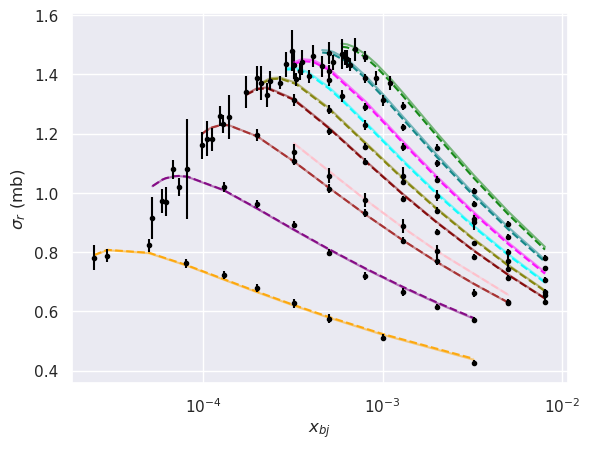

In [159]:
plot_exp_vs_map_vs_median([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, MAPT_values, exp_df, median_values)

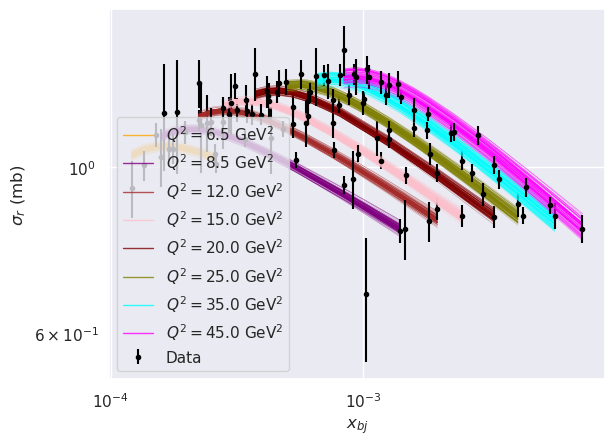

In [88]:
plot_model_vs_exp([6.5, 8.5, 12.0, 15.0, 20.0, 25.0, 35.0, 45.0], 251.0, model_values, exp_df)

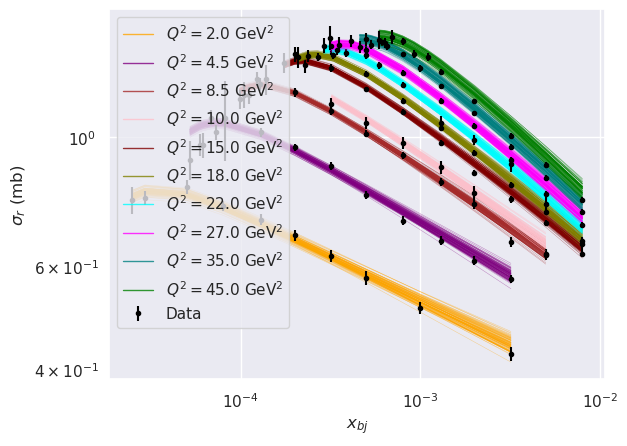

In [89]:
plot_model_vs_exp([2., 4.5, 8.5, 10., 15., 18.,  22.,  27.,  35.,  45.], 318.0, model_values, exp_df)


In [163]:
exp_df[['Qs2', 'sqrt(s)']].value_counts().to_frame()

,,0
Qs2,sqrt(s),
12.0,251.0,15
8.5,318.0,14
45.0,251.0,14
6.5,318.0,14
35.0,251.0,14
3.5,318.0,14
4.5,318.0,14
15.0,251.0,14
2.7,318.0,13


In [140]:
def my_chi2(data, obs, obs_err):
    return np.sum(((data - obs)**2)/obs_err**2)/403


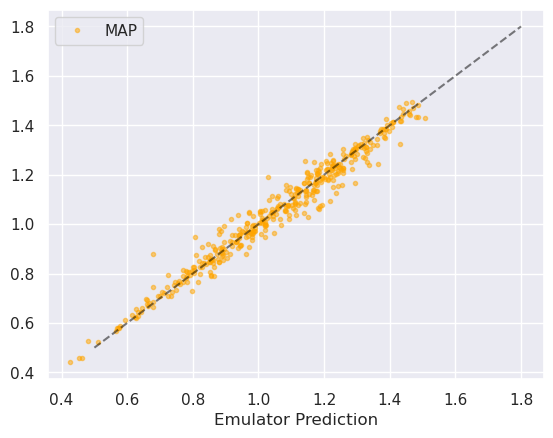

In [192]:
diag = np.linspace(0.5, 1.8)
#plt.plot(exp, median_values.reshape(403), '.', color = 'blue', alpha = 0.5, label = 'Median');
plt.plot(exp, MAPT_values.reshape(403), '.', color = 'orange', alpha = 0.5, label = 'MAP');
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)
plt.xlabel("Emulator Prediction")
plt.legend()
#plt.ylabel("Model Prediction")

In [196]:
map_x = my_chi2(MAPT_values, exp, exp_err)
median_x = my_chi2(median_values, exp, exp_err)
#chi2(MAPT_values, exp, exp_err)
print('$$\chi^{2}/dof$$ (MAP):' , map_x)
print('$$\chi^{2}/dof$$ (Median):' , median_x)

$$\chi^{2}/dof$$ (MAP): 1.288195855559546
$$\chi^{2}/dof$$ (Median): 1.5049359891529395


In [191]:
thetas = np.vstack(np.loadtxt("results/theta.dat", unpack = True)).T
lps = [log_posterior(i, l_bounds, u_bounds, emulators, exp, exp_err) for i in thetas]
print(np.array(lps).T)

[ -5.30027818 440.92518208 440.9307657  440.92945155 440.73990143
 113.17024813 293.94061588 134.66433146  88.59442271]


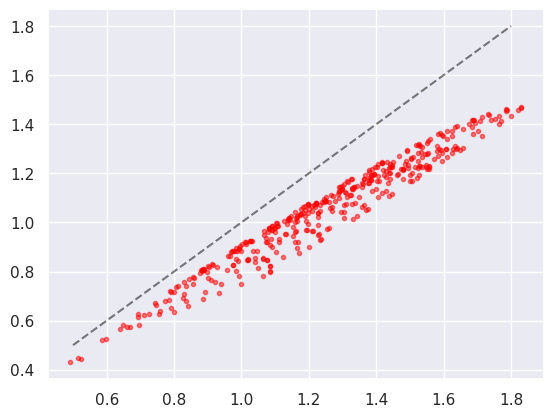

In [214]:
diag = np.linspace(0.5, 1.8)
MAPT_values_model = np.array(np.loadtxt("results/trains/0.txt"))
int = initial_guess.reshape(1, -1) 
initial_values, initial_values_err = return_predictions(emulators, int, return_std_ = True)
#plt.plot(exp, MAPT_values.reshape(403), '.', color = 'orange', alpha = 0.5, label = 'MAP');
#plt.plot(exp, MAPT_values_model, '.', color = 'blue', alpha = 0.5, label = 'MAP');
plt.plot(initial_values.reshape(403), MAPT_values_model, '.', color = 'red', alpha = 0.5, label = 'MAP');
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)
#plt.errorbar(MAPT_values_model, MAPT_values.reshape(403), yerr = MAPT_values_err, fmt='.')